In [2]:
import numpy as np
import pandas as pd

In [3]:
# data loader
df1 = pd.read_excel('原始数据.xlsx',sheet_name='最高气温')
df2 = pd.read_excel('原始数据.xlsx',sheet_name='最低气温')
df3 = pd.read_excel('原始数据.xlsx',sheet_name='RH')
df4 = pd.read_excel('原始数据.xlsx',sheet_name='风速')
df5 = pd.read_excel('原始数据.xlsx',sheet_name='ET0')
data1 = df1.values.T 
data2 = df2.values.T
data3 = df3.values.T
data4 = df4.values.T
data5 = df5.values.T

一共有12个月的数据，所以一共分成12个数据集，训练12个神经网络。
接下来，只实现1一个月的，比如1月


In [4]:
month_choice = 0
train_data = np.array([data1[month_choice],data2[month_choice],data3[month_choice],data4[month_choice]]).T
label_data = data5[month_choice] 
all_data = np.array([data1[month_choice],data2[month_choice],data3[month_choice],data4[month_choice],data5[month_choice]]).T
X_train,y_train = train_data,label_data
#X_test,y_test =  train_data[30:],label_data[30:]
import sklearn.neural_network as sk_nn
model = sk_nn.MLPRegressor(activation='relu',solver='adam',alpha=0.0001,learning_rate='adaptive',learning_rate_init=0.001,max_iter=1000)
model.fit(X_train,y_train)
#acc=model.score(X_test,y_test) #根据给定数据与标签返回正确率的均值
#print('神经网络模型评价:',acc)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [5]:
# 正态性检验
from scipy.stats import shapiro
 
[shapiro(all_data[:,i]) for i in range(4)]

[(0.9947386980056763, 0.9996803402900696),
 (0.9521321058273315, 0.11304868757724762),
 (0.9824049472808838, 0.8121331930160522),
 (0.987708568572998, 0.9491970539093018)]

In [6]:
from scipy.stats import norm

# 先验
priori_mean = np.array([all_data[:,i].mean() for i in range(4)])
priori_std = [all_data[:,i].std() for i in range(4)]
priori_cov = np.diag(priori_std)

g = lambda x: np.prod([norm.pdf(x[i],priori_mean[i],priori_std[i]) for i in range(4)])
f = lambda x : model.predict(np.array([x])) # input is an 4-d list


In [9]:
# AM-MCMC

def AMCMC(e = 1e-3, t0 = 2000, itr = 10000,p_m = priori_mean,p_c = priori_cov):
    """
    e: 极小的常数
    t0: 预热期
    itr: 迭代总次数
    p_m: 先验均值
    p_c: 先验协方差
    
    """
    
    # parameters
    d = 4
    sd = ((2.4)**2)/d
    out_put = np.array([p_m]*itr)
    C = np.array([p_c]*itr) # cov matrix in each iteration
    R_sqrt = np.zeros(itr)
    
    # MAIN
    for i in range(1,itr):
        if i < t0: # 预热期
            C[i] = p_c
        else:
            x,y,z = out_put[:i-1].mean(axis=0),out_put[:i].mean(axis=0),out_put[i-1]
            C[i] = ((i-2)/(i-1))*C[i-1]+(sd/(i-1))*((i-1)*(x.T.dot(x))-(i)*(y.T.dot(y))+z.T.dot(z)+e*np.eye(d))

        X_star = np.random.multivariate_normal(out_put[i-1],C[i])
        a = min(1,(f(X_star)*g(X_star))/(f(out_put[i-1])*g(out_put[i])))
        u = np.random.rand()

        if u <= a:
            out_put[i] = X_star
        else:
            out_put[i] = out_put[i-1]
            
    return (out_put[t0:])


In [10]:
# 数据
l_1,l_2,l_3,l_4 = AMCMC()[:,0],AMCMC()[:,1],AMCMC()[:,2],AMCMC()[:,3]

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns  #习惯上简写成snssns.set()           
sns.set()#切换到seaborn的默认运行配置

<Figure size 432x288 with 0 Axes>

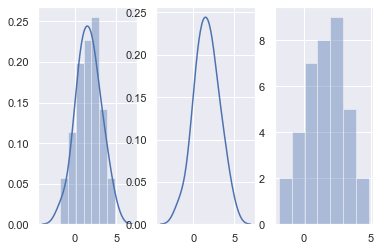

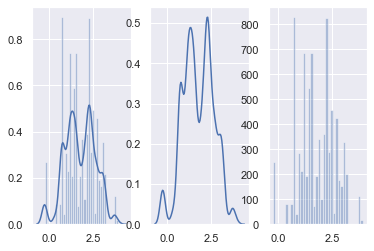

In [25]:


# 作图
# 最高气温
# 先验密度
plt.figure(0)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(data1[month_choice],ax=axes[0]) #左图
sns.distplot(data1[month_choice],hist=False,ax=axes[1]) #中图
sns.distplot(data1[month_choice],kde=False,ax=axes[2]) #右图
# 后验密度
plt.figure(1)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(l_1,ax=axes[0]) #左图
sns.distplot(l_1,hist=False,ax=axes[1]) #中图
sns.distplot(l_1,kde=False,ax=axes[2]) #右图





<Figure size 432x288 with 0 Axes>

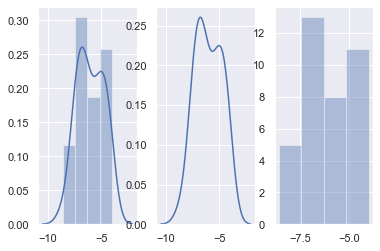

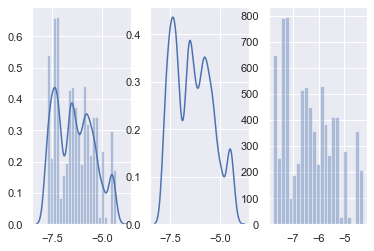

In [26]:
# 最低气温
# 先验密度
plt.figure(0)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(data2[month_choice],ax=axes[0]) #左图
sns.distplot(data2[month_choice],hist=False,ax=axes[1]) #中图
sns.distplot(data2[month_choice],kde=False,ax=axes[2]) #右图
# 后验密度
plt.figure(1)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(l_2,ax=axes[0]) #左图
sns.distplot(l_2,hist=False,ax=axes[1]) #中图
sns.distplot(l_2,kde=False,ax=axes[2]) #右图


<Figure size 432x288 with 0 Axes>

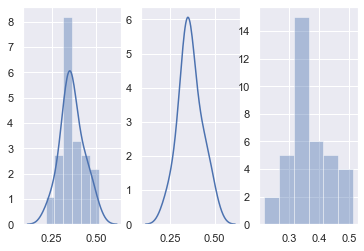

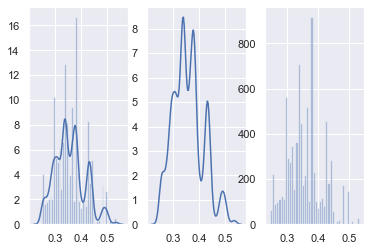

In [27]:
# RH
# 先验密度
plt.figure(0)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(data3[month_choice],ax=axes[0]) #左图
sns.distplot(data3[month_choice],hist=False,ax=axes[1]) #中图
sns.distplot(data3[month_choice],kde=False,ax=axes[2]) #右图
# 后验密度
plt.figure(1)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(l_3,ax=axes[0]) #左图
sns.distplot(l_3,hist=False,ax=axes[1]) #中图
sns.distplot(l_3,kde=False,ax=axes[2]) #右图

<Figure size 432x288 with 0 Axes>

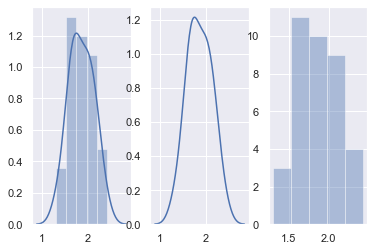

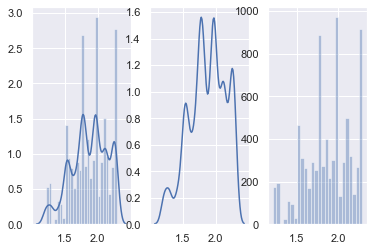

In [28]:
# 风速
# 先验密度
plt.figure(0)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(data4[month_choice],ax=axes[0]) #左图
sns.distplot(data4[month_choice],hist=False,ax=axes[1]) #中图
sns.distplot(data4[month_choice],kde=False,ax=axes[2]) #右图
# 后验密度
plt.figure(1)
fig,axes=plt.subplots(1,3) #创建一个一行三列的画布
sns.distplot(l_4,ax=axes[0]) #左图
sns.distplot(l_4,hist=False,ax=axes[1]) #中图
sns.distplot(l_4,kde=False,ax=axes[2]) #右图

In [43]:
# 算期望
mean = [l_1.mean(),l_2.mean(),l_3.mean(),l_4.mean()]
mean 

[1.7663489752787054,
 -6.35860504550071,
 0.35766959177409674,
 1.8714679810124168]

In [41]:
# 输出数据

out = np.array([l_1,l_2,l_3,l_4]).T
out = pd.DataFrame(out)
writer = pd.ExcelWriter('my.xlsx')
out.to_excel(writer,float_format='%.5f')
writer.save()